Starting experiment Part A: Impact of irrelevant features


Noise Features:   0%|          | 0/3 [00:00<?, ?it/s]

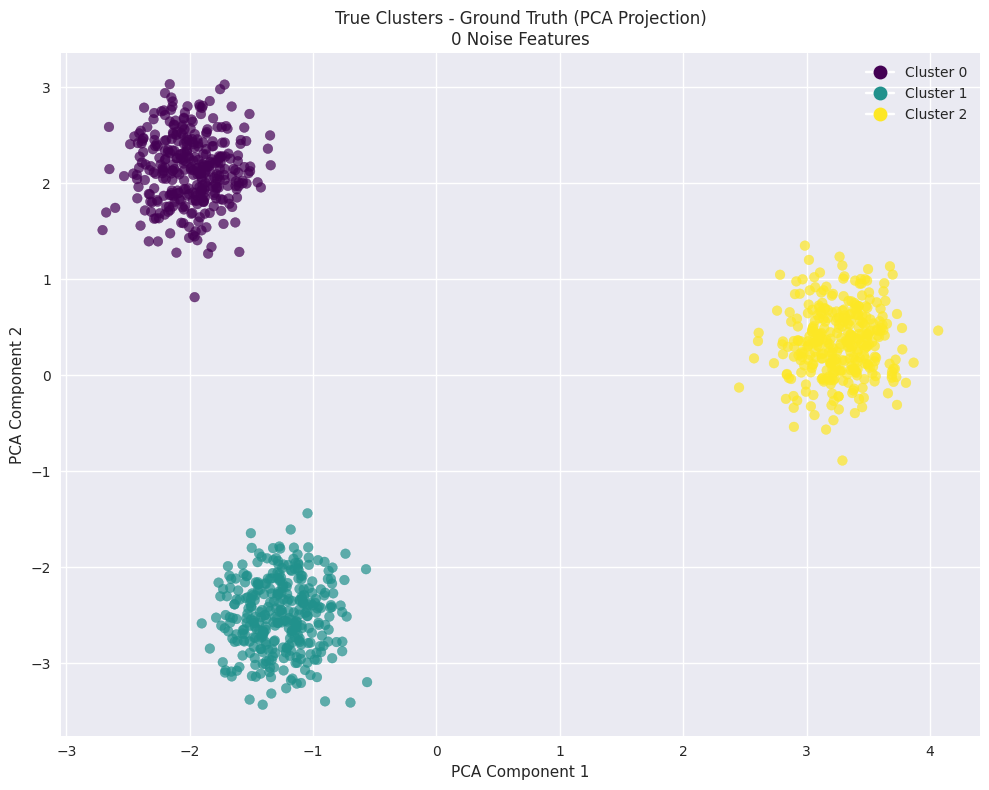

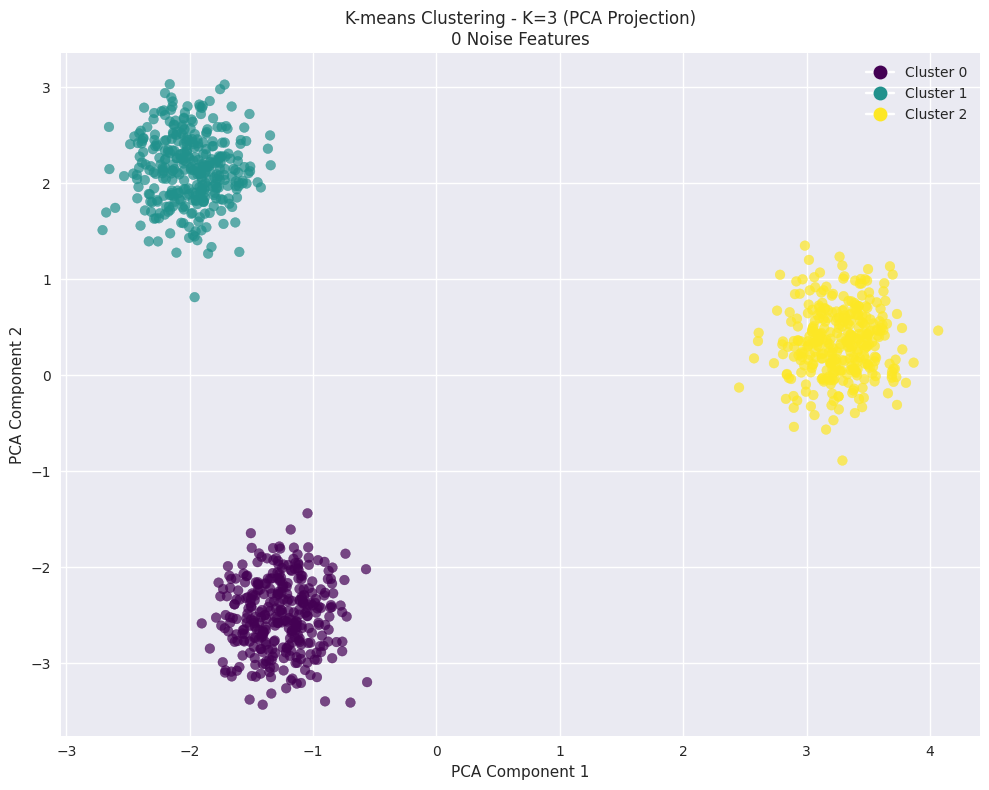

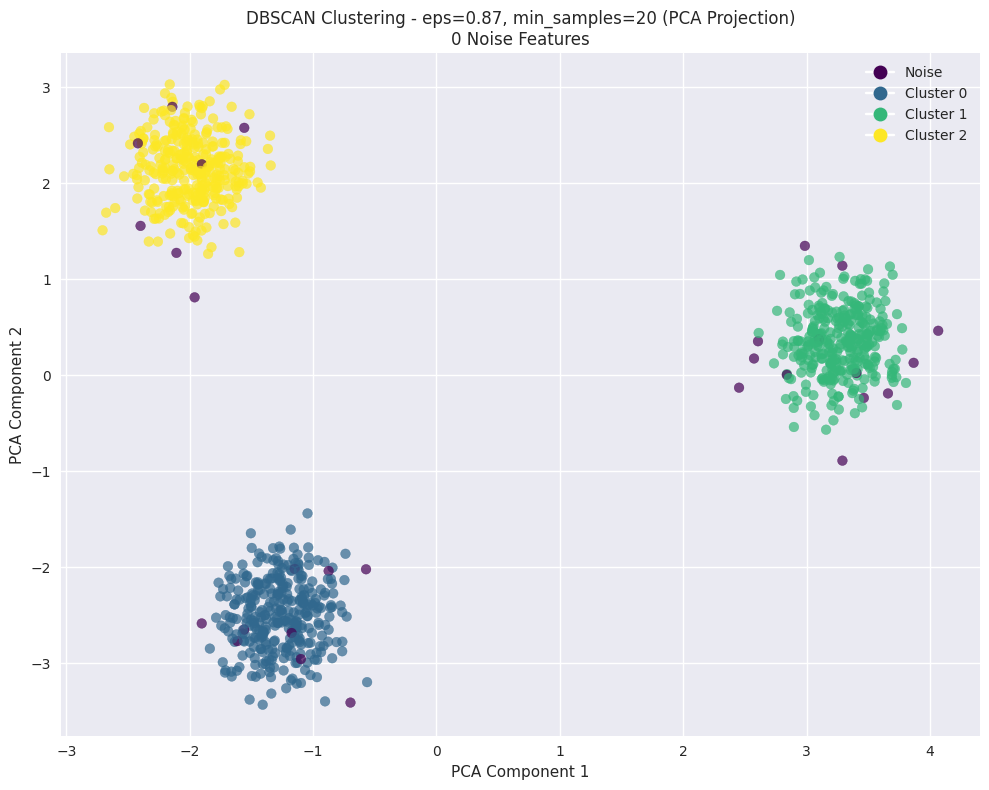

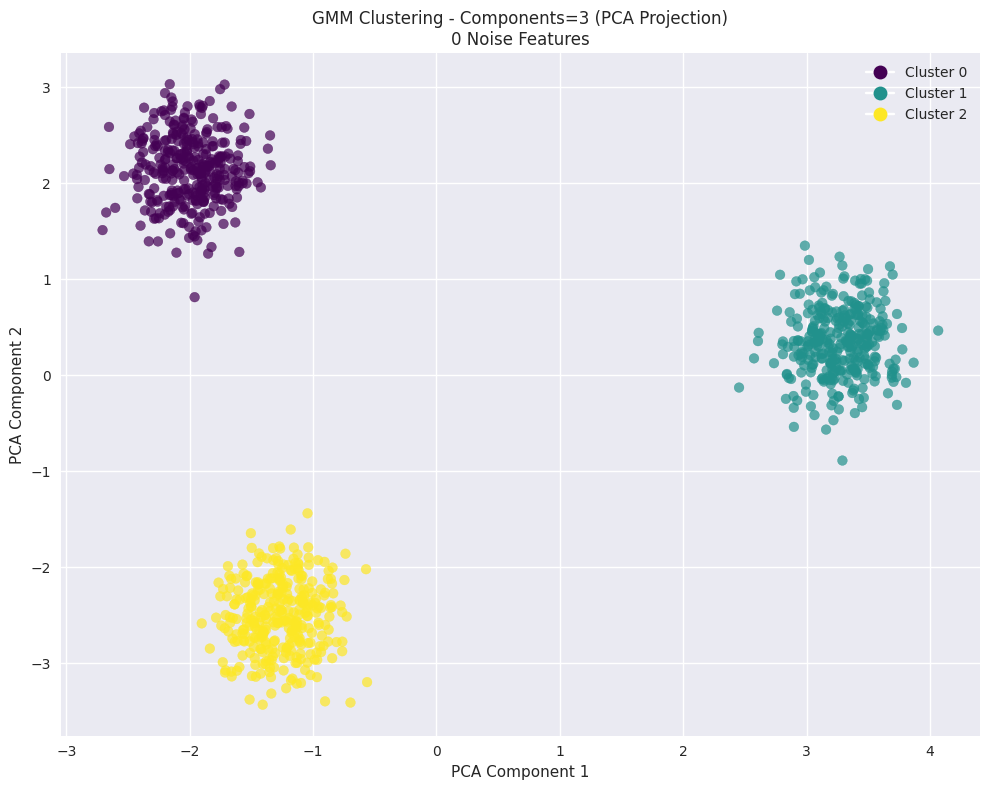


Noise Features:  33%|███▎      | 1/3 [00:06<00:12,  6.31s/it]

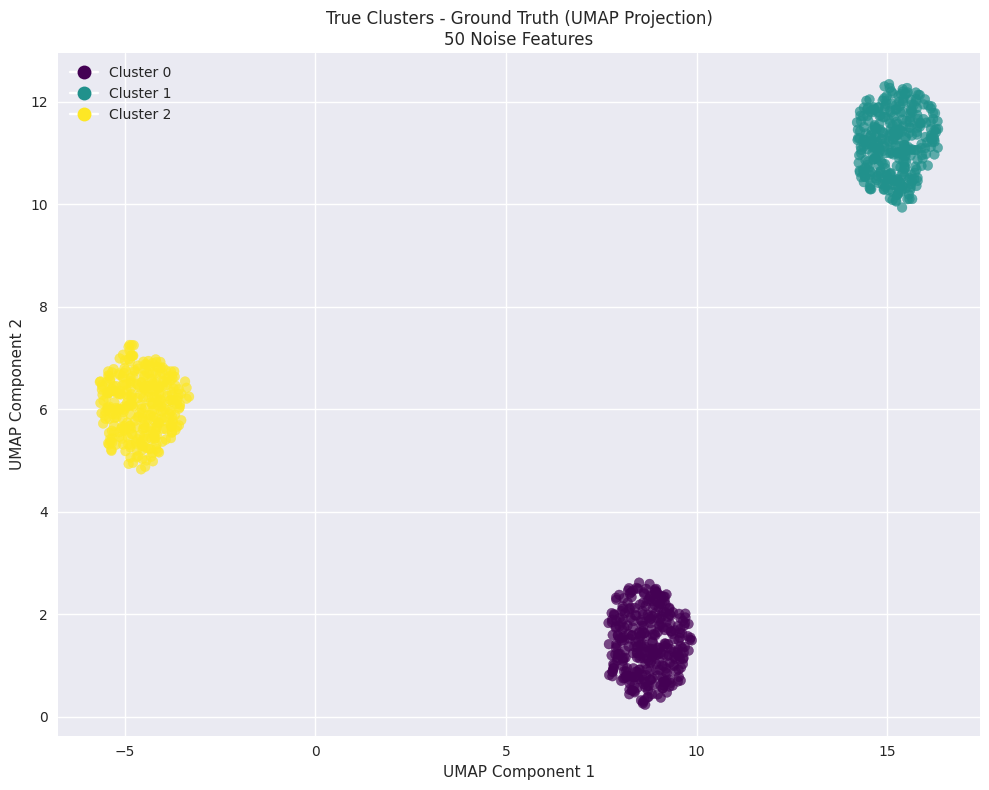

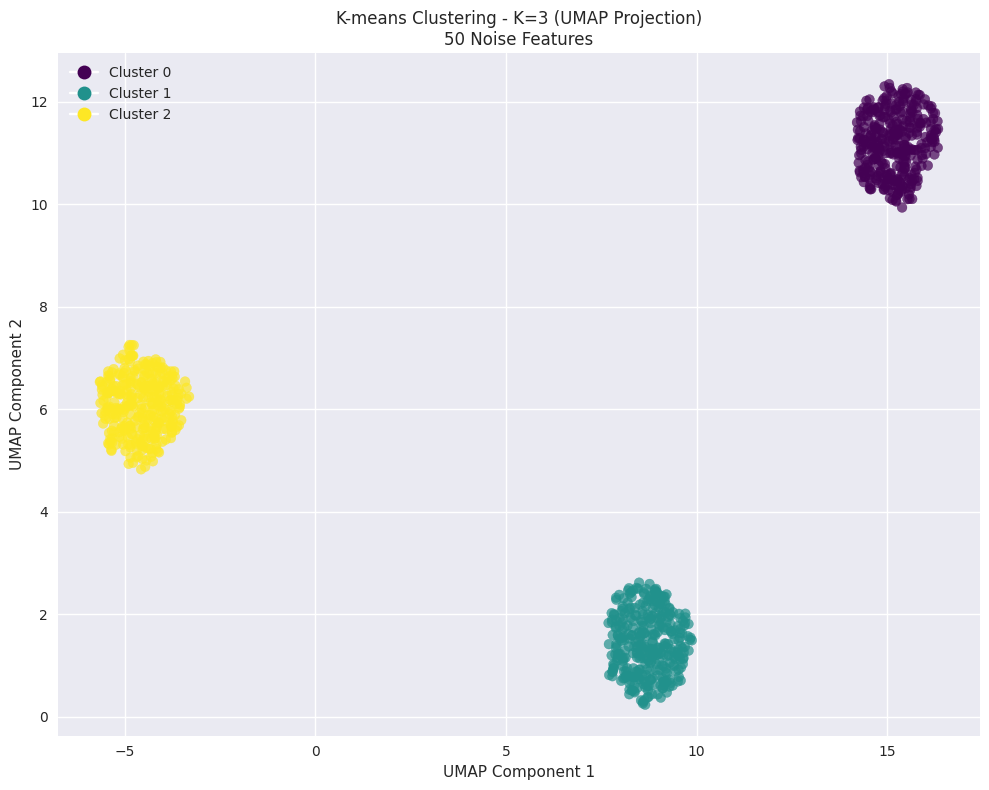

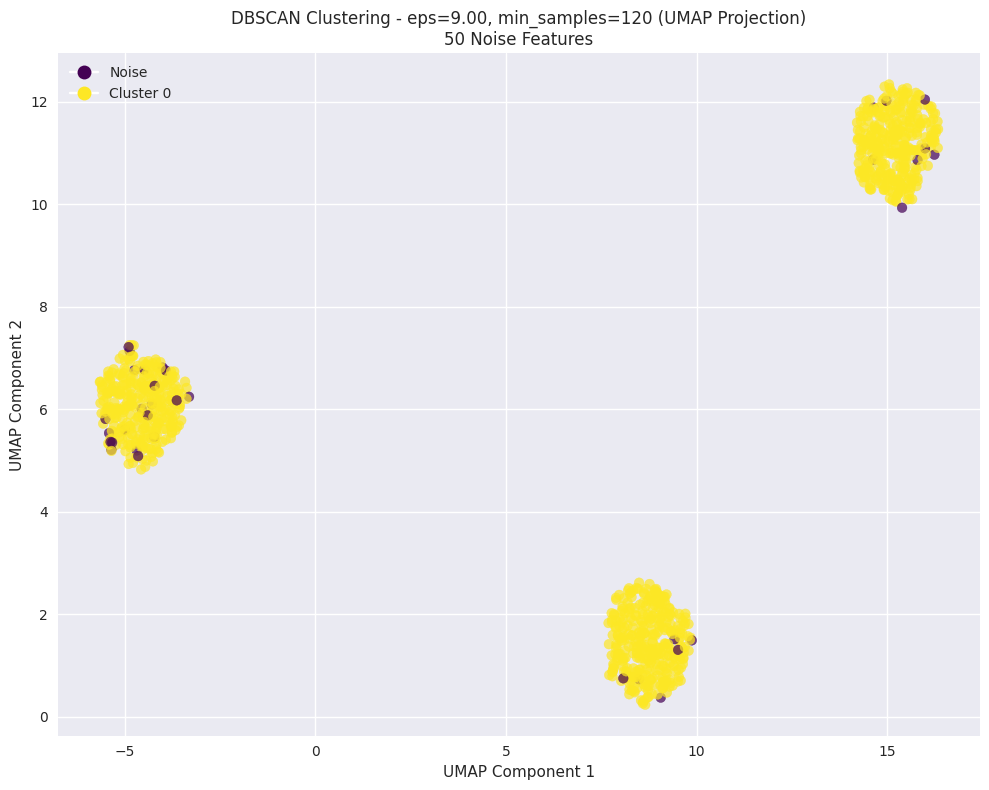

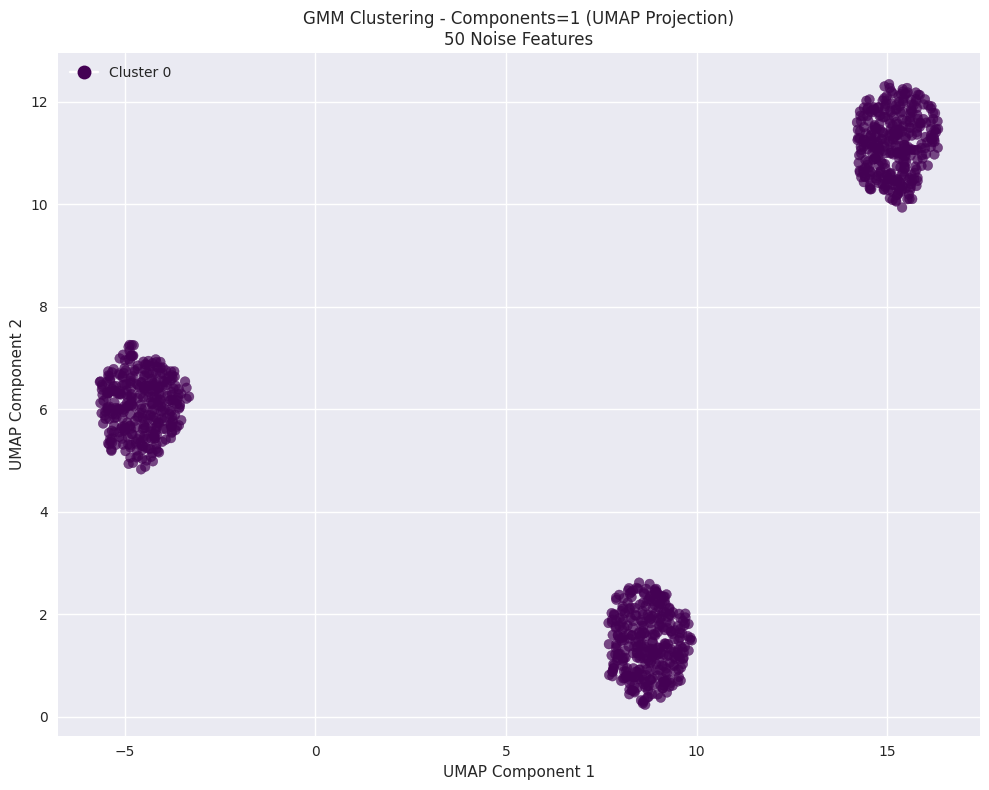


Noise Features:  67%|██████▋   | 2/3 [00:23<00:12, 12.47s/it]

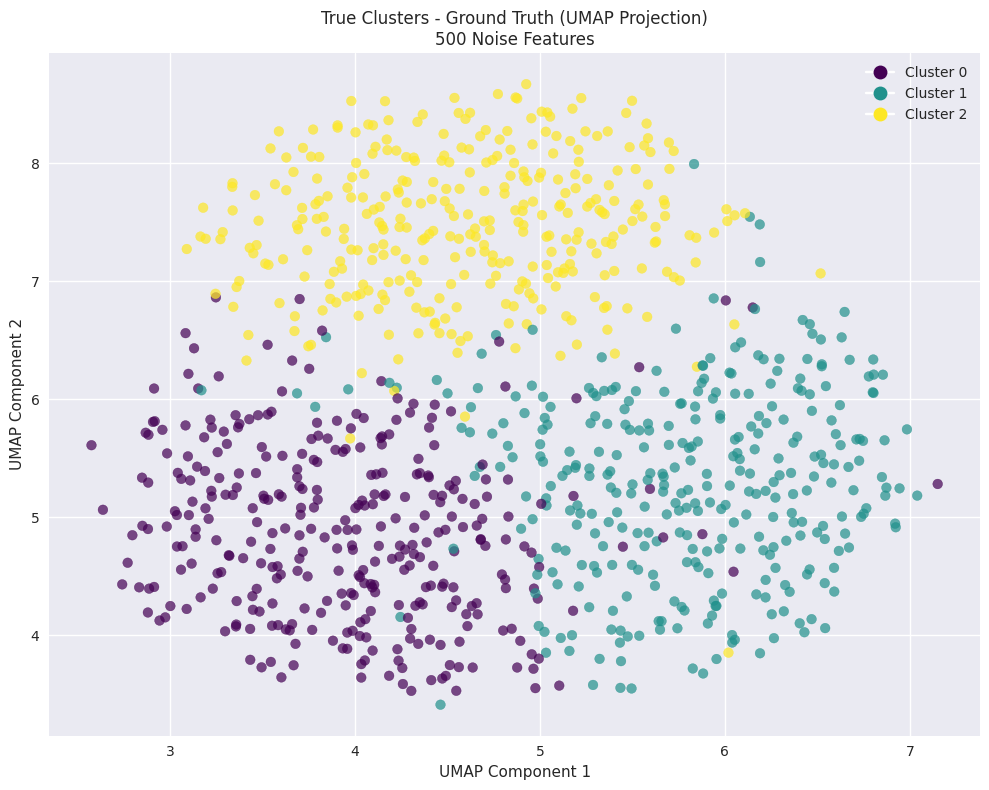

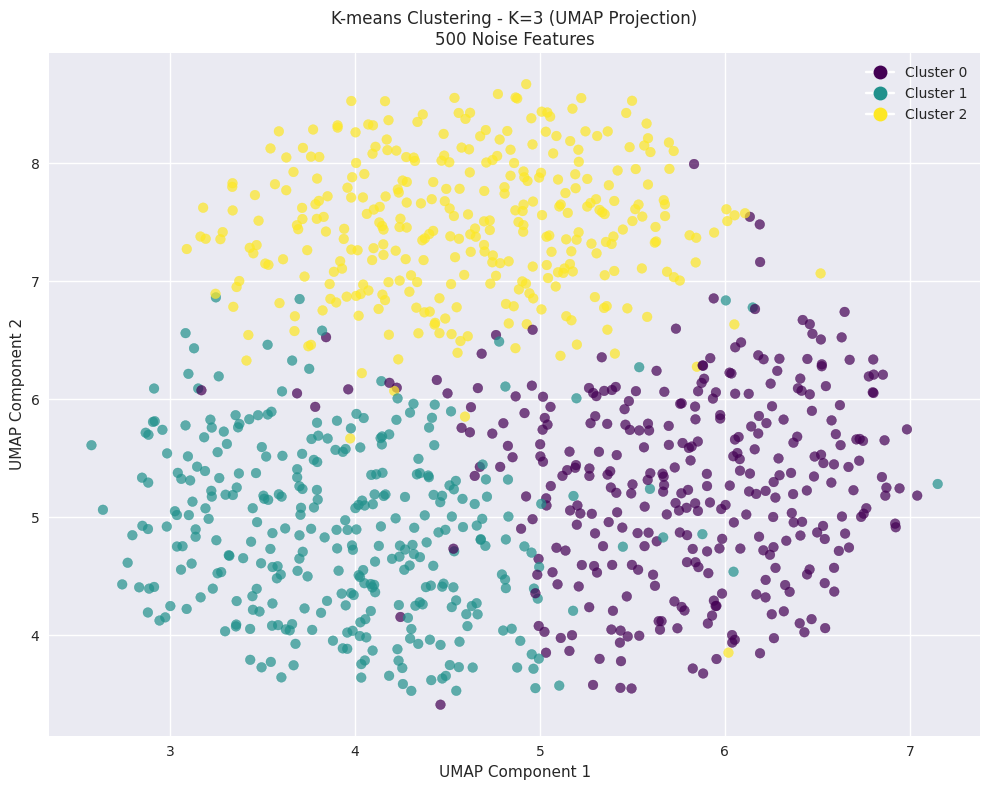

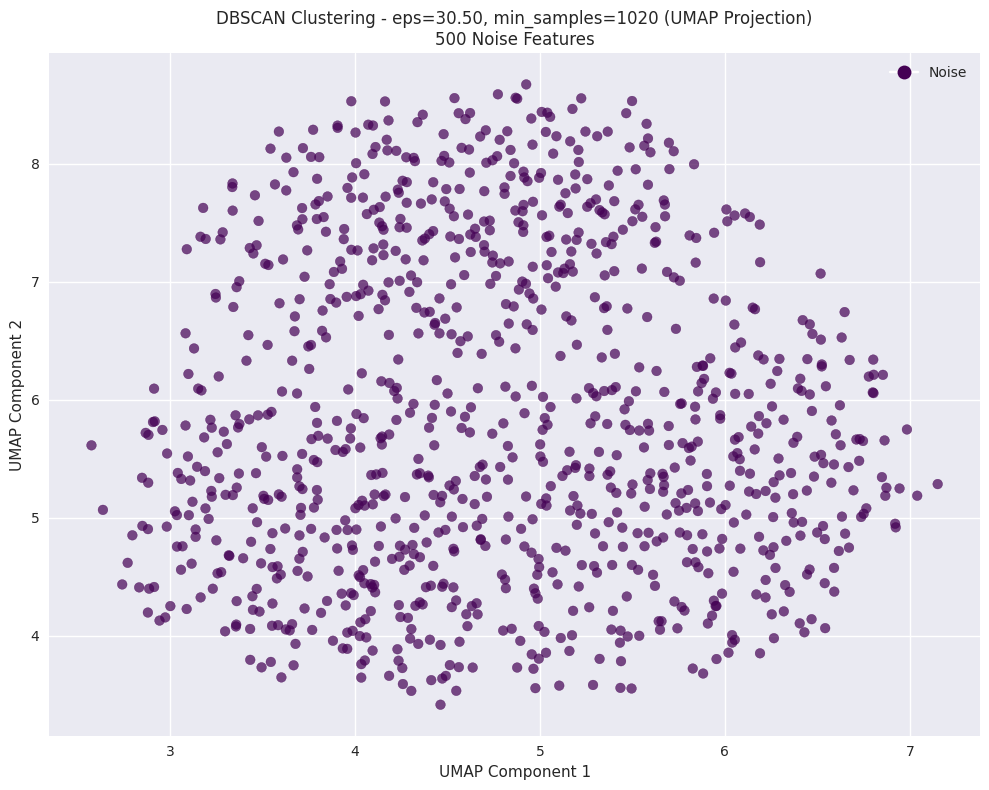

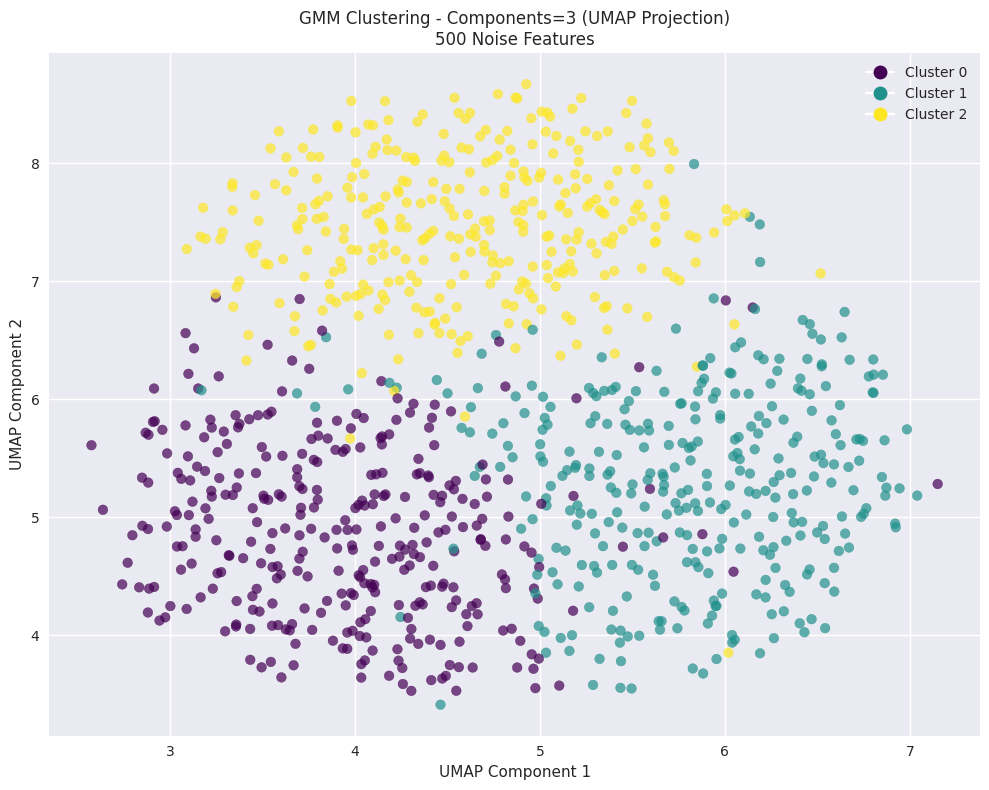


Part A Repetitions: 100%|██████████| 1/1 [01:25<00:00, 85.84s/it]


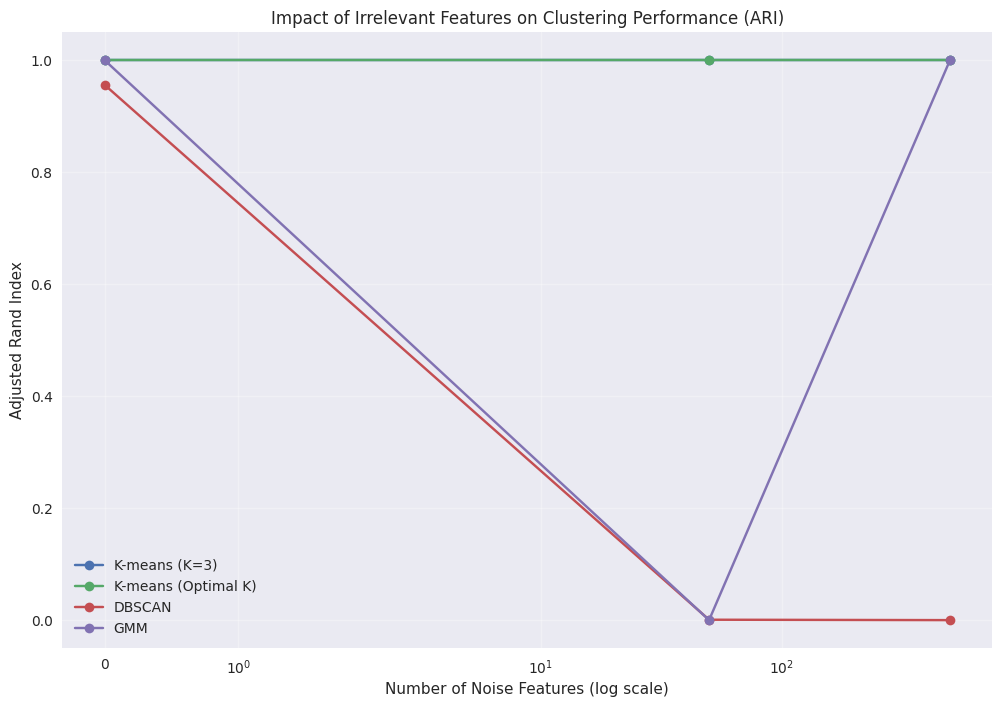

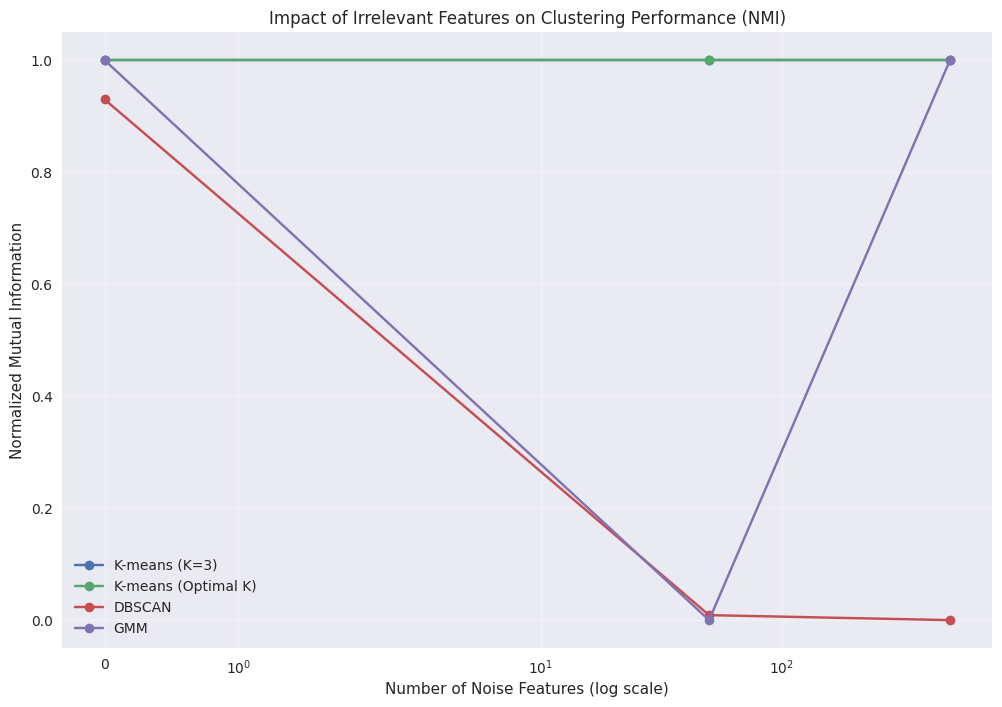

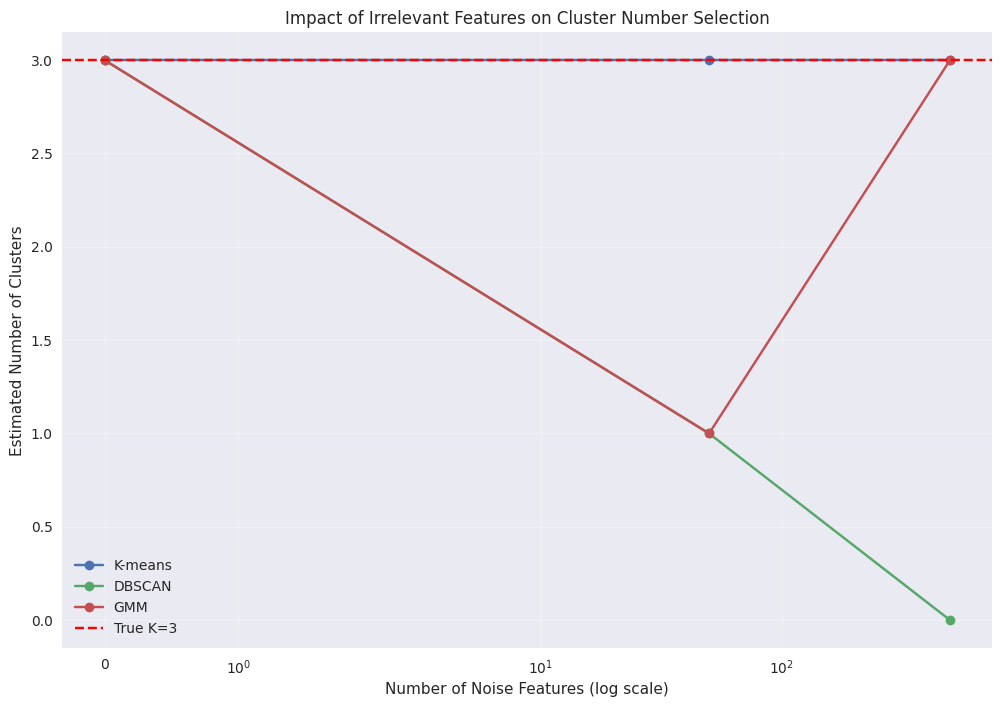


Starting experiment Part B: Impact of noise observations


Noise Percentages:   0%|          | 0/3 [00:00<?, ?it/s]

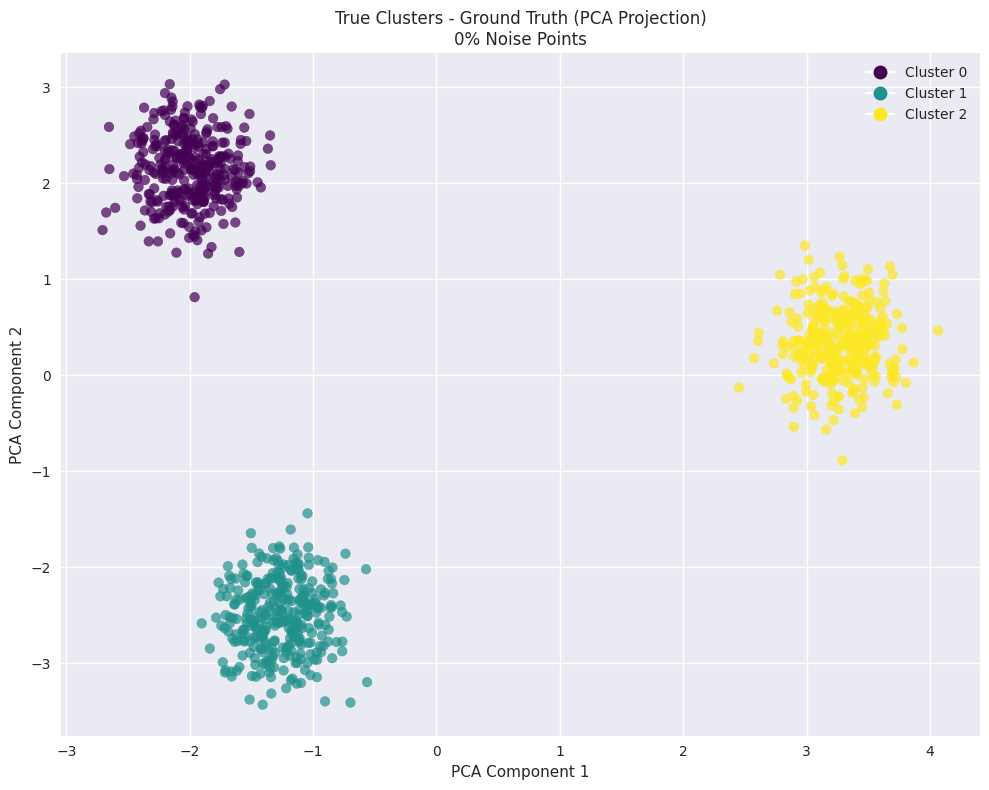

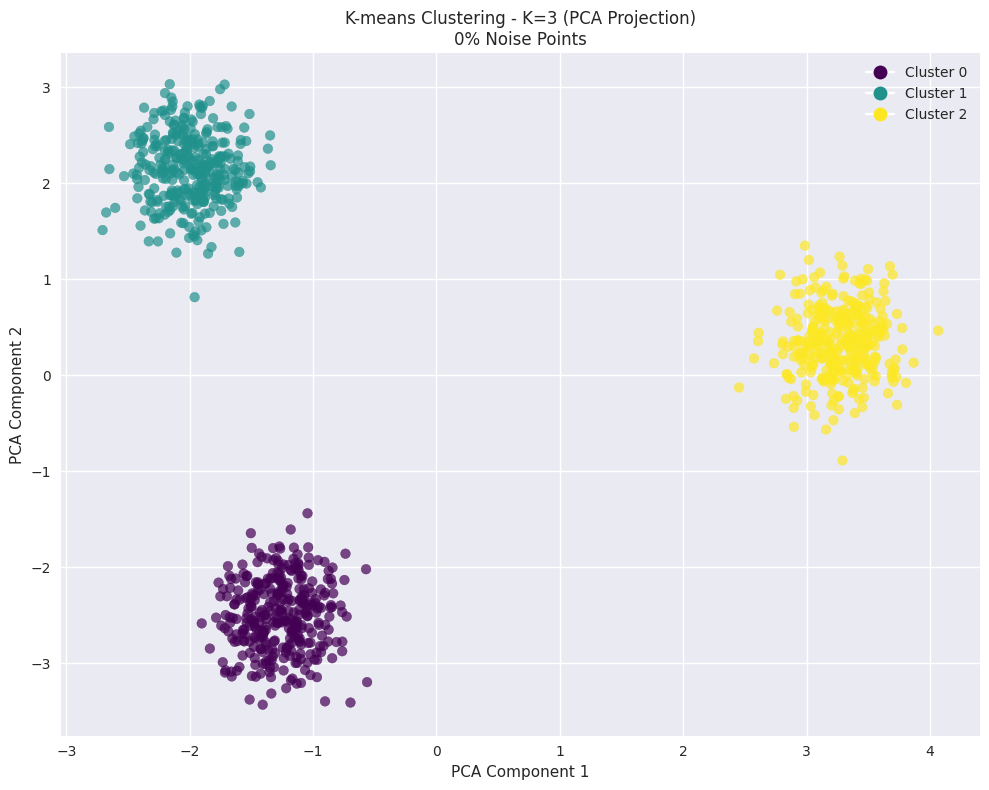

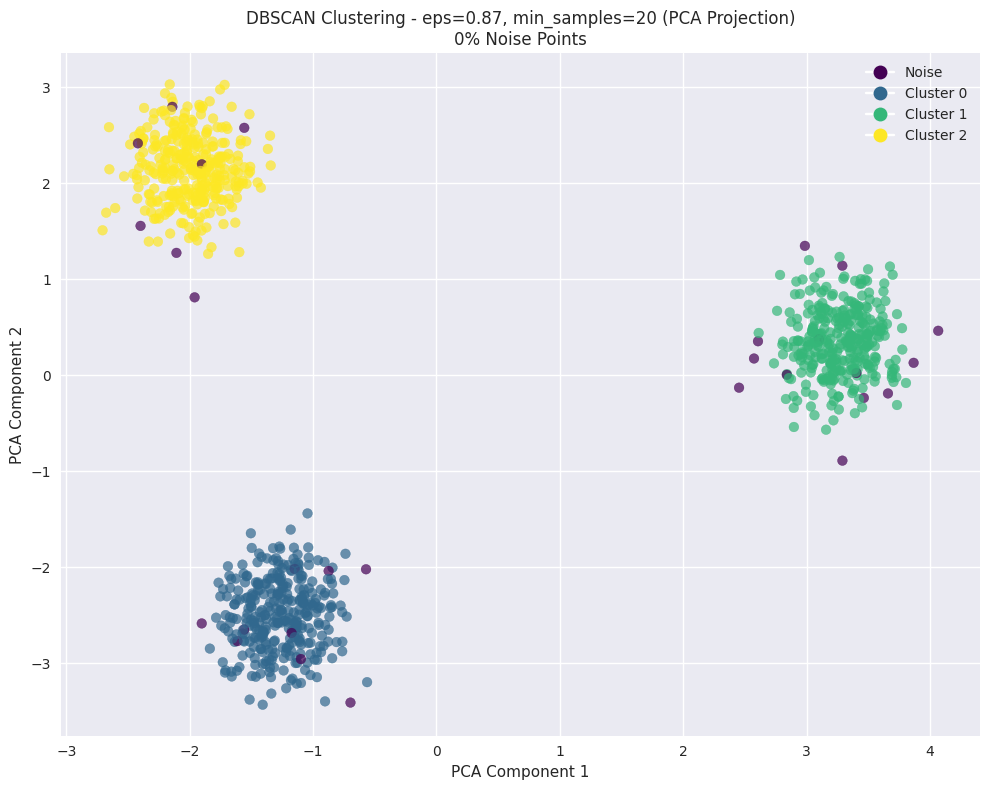

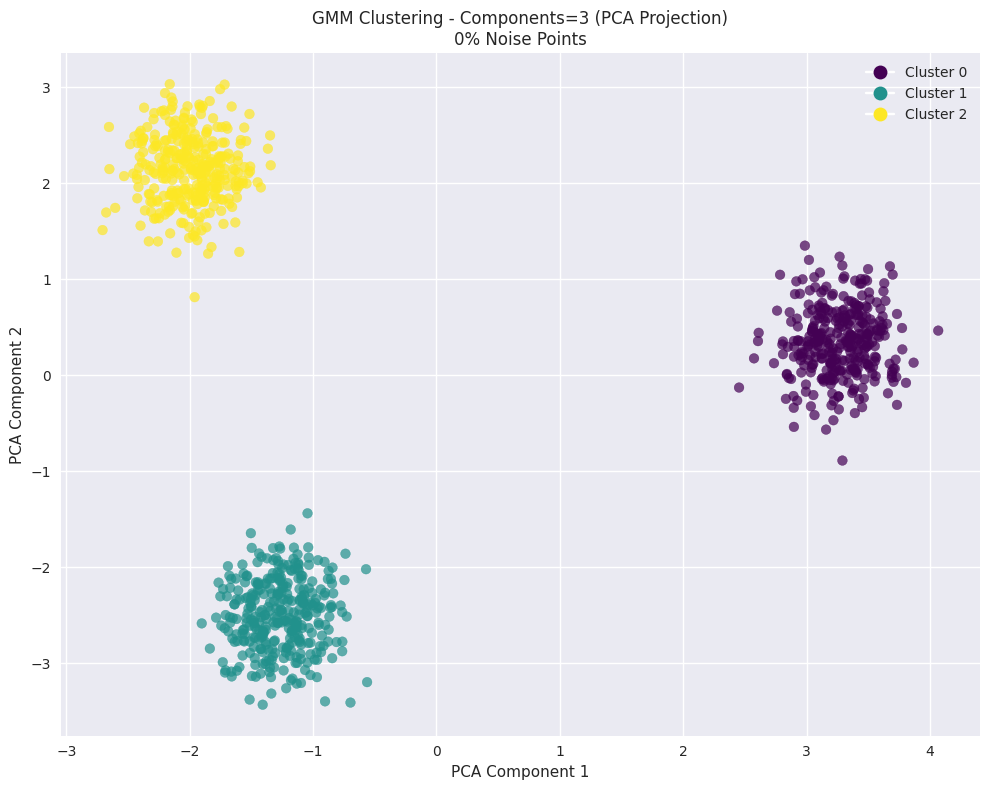


Noise Percentages:  33%|███▎      | 1/3 [00:06<00:12,  6.29s/it]

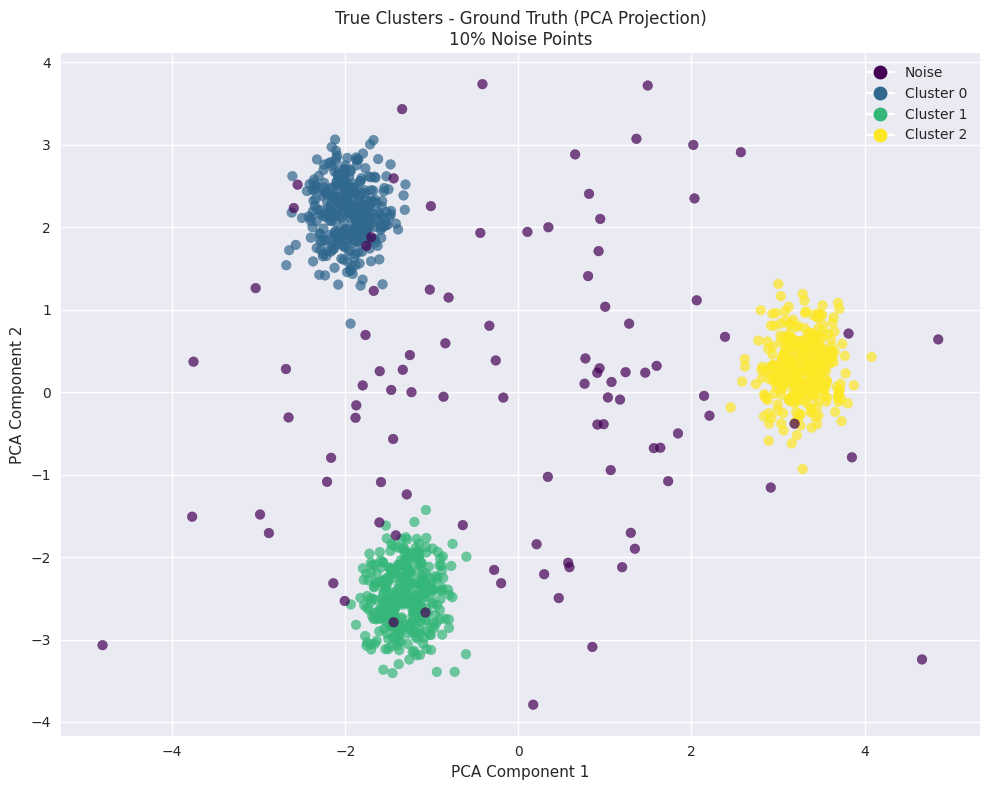

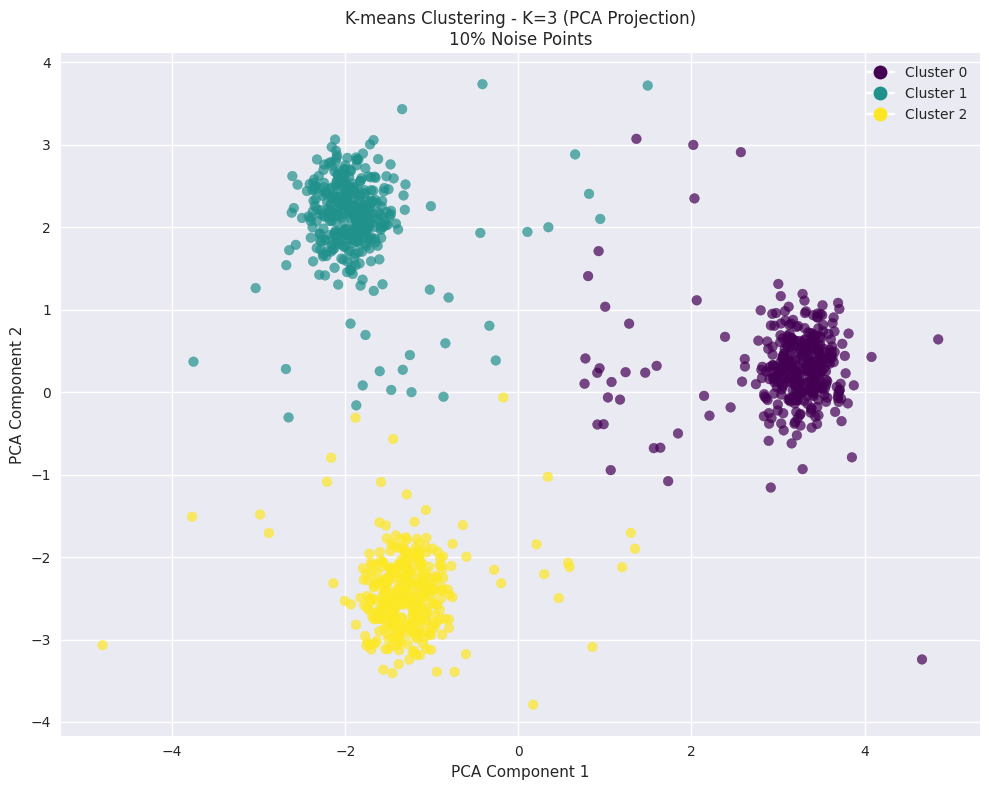

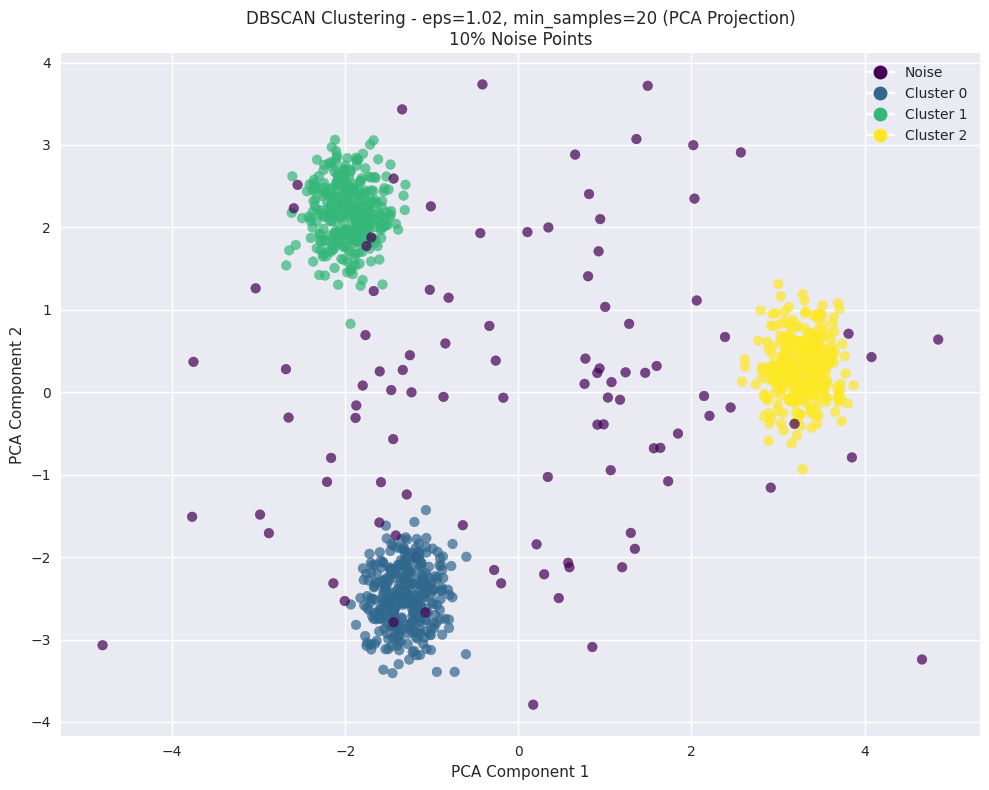

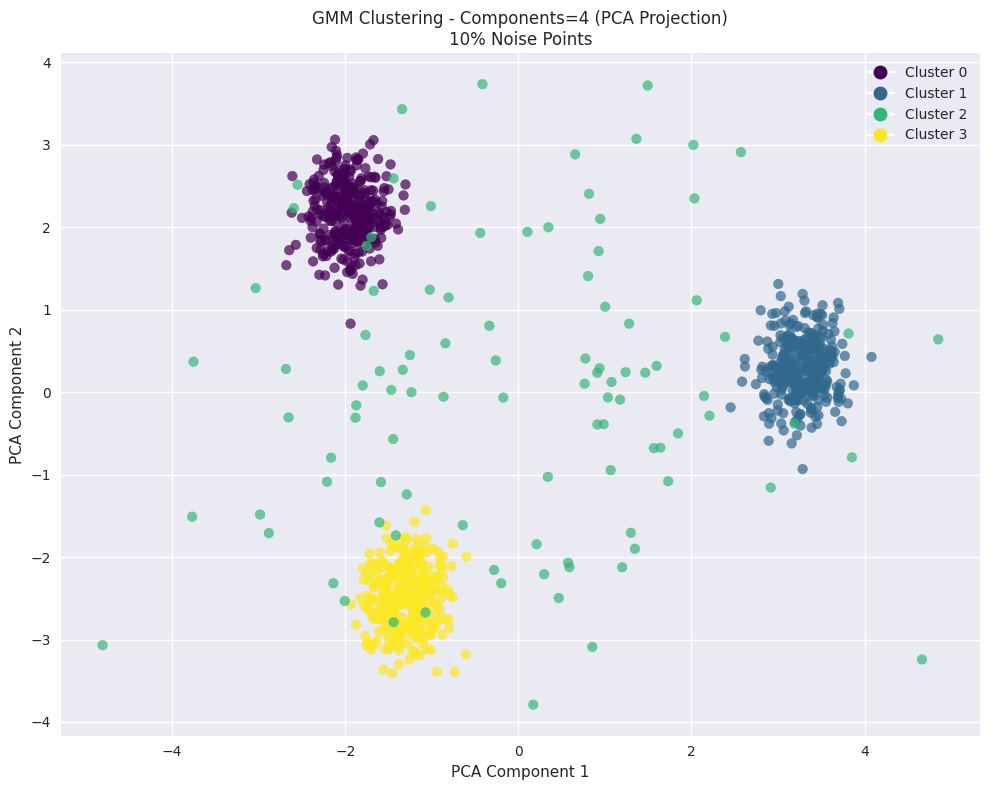


Noise Percentages:  67%|██████▋   | 2/3 [00:10<00:05,  5.12s/it]

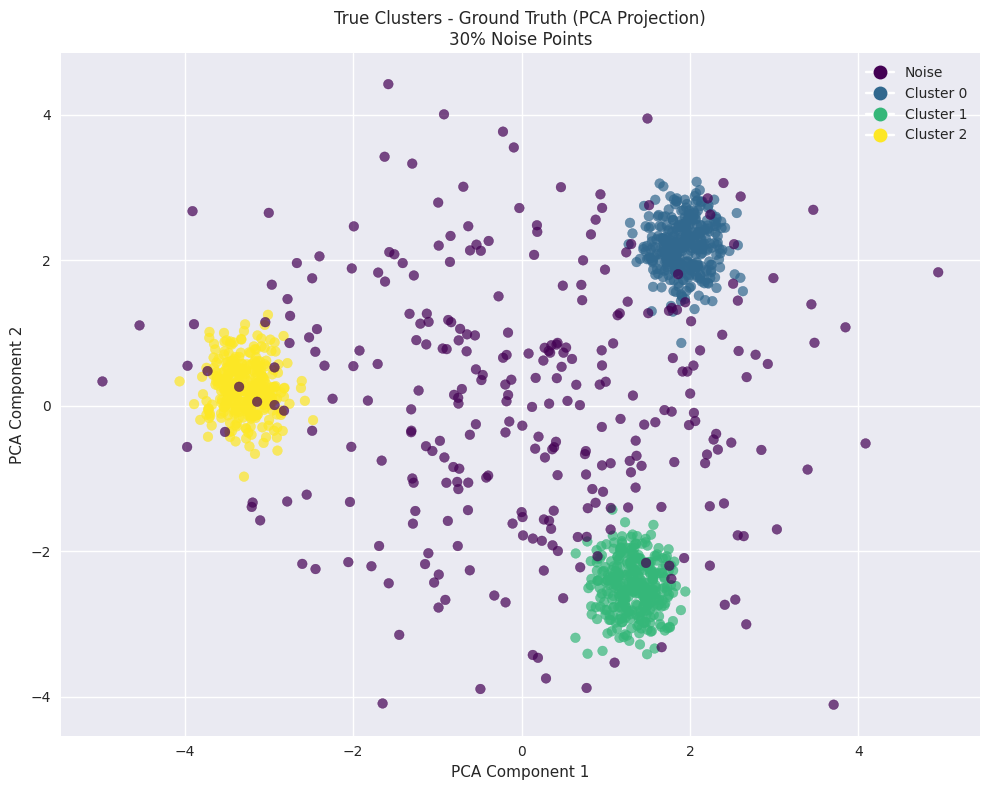

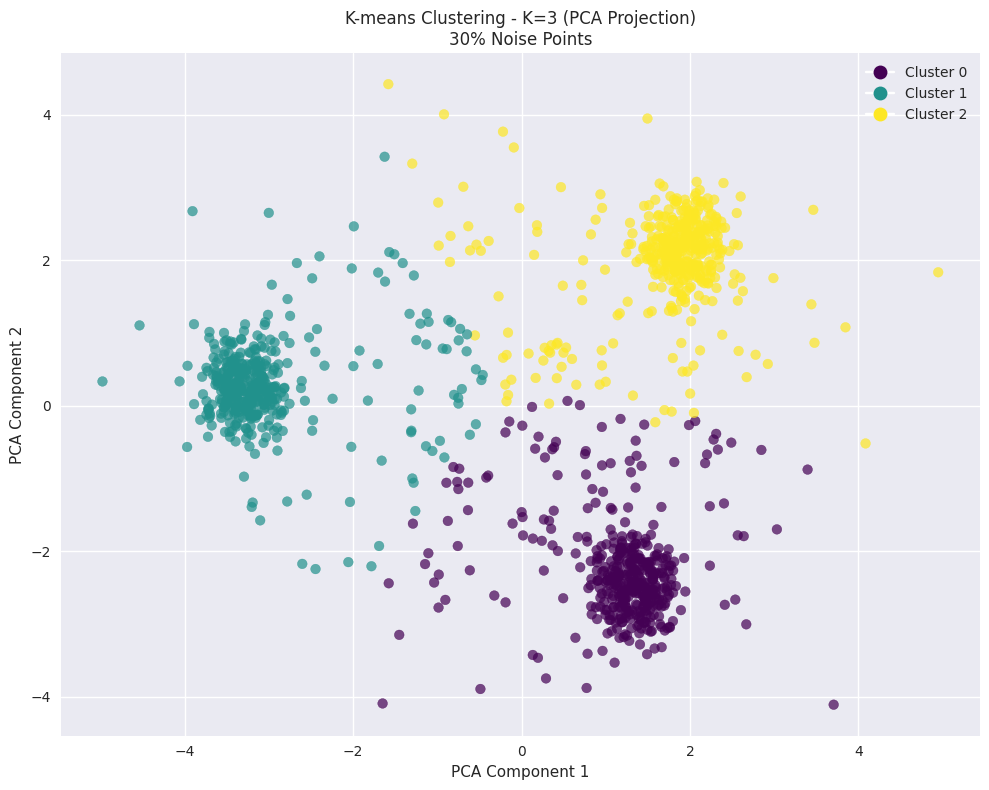

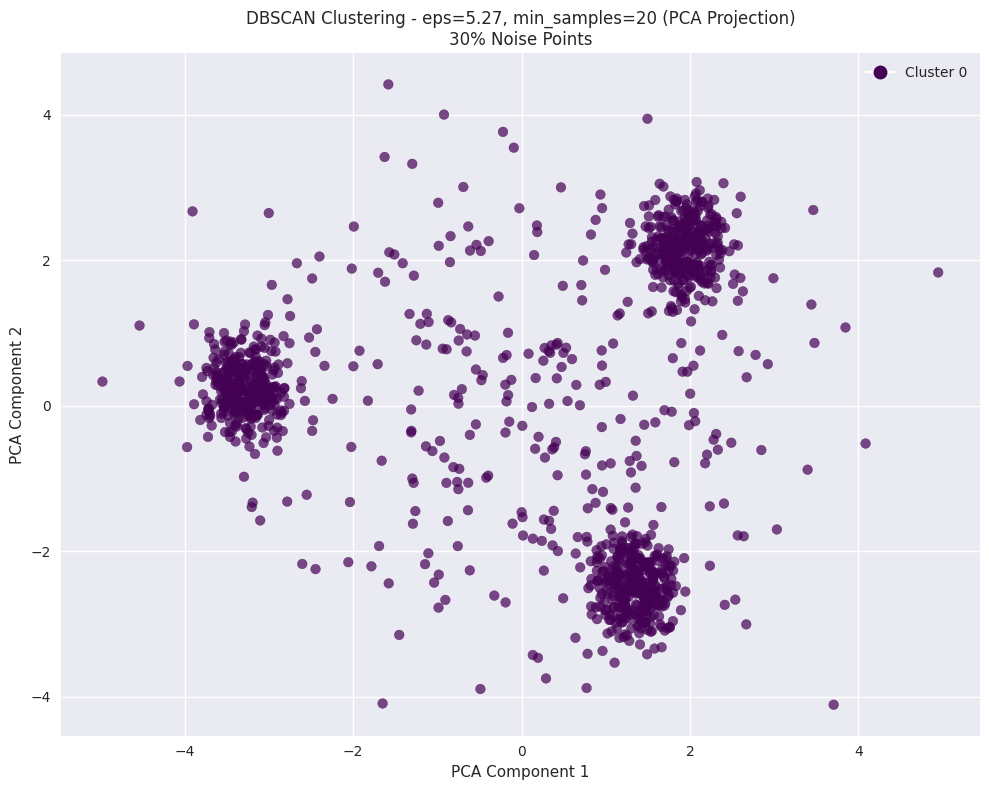

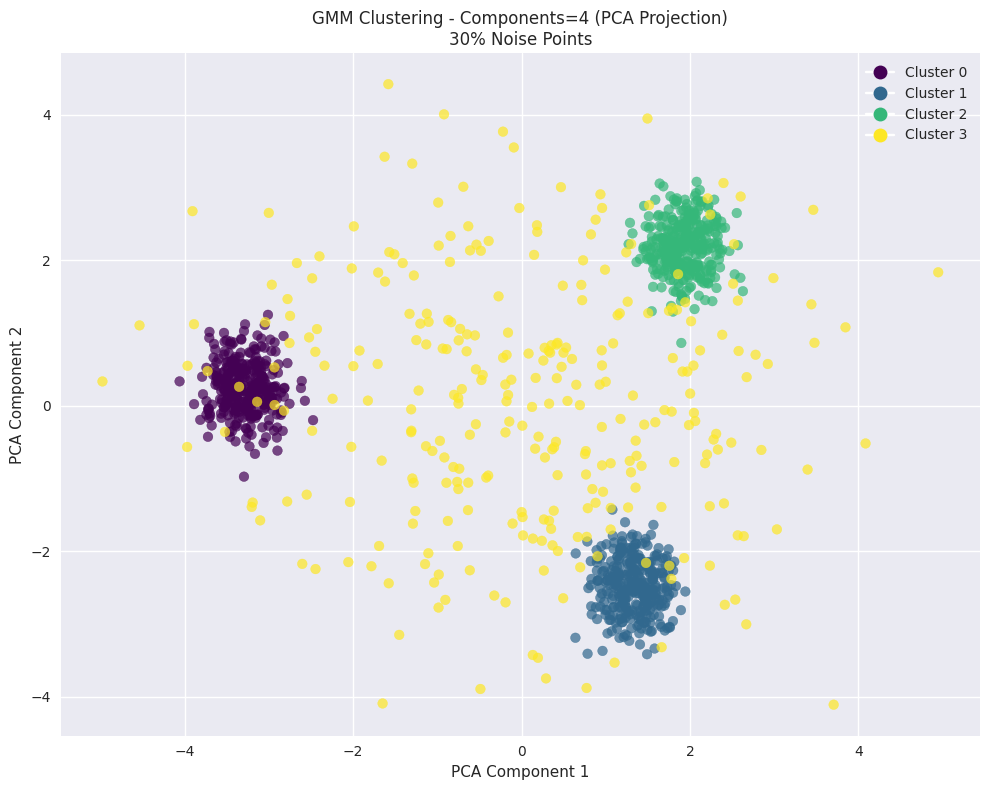


Part B Repetitions: 100%|██████████| 1/1 [00:15<00:00, 15.50s/it][A


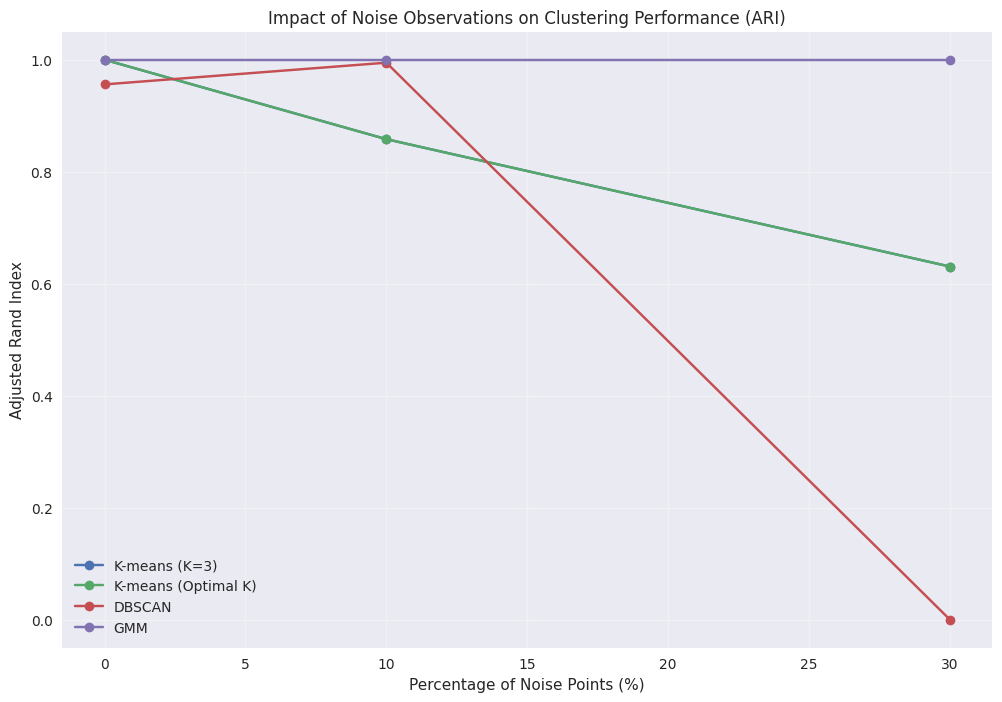

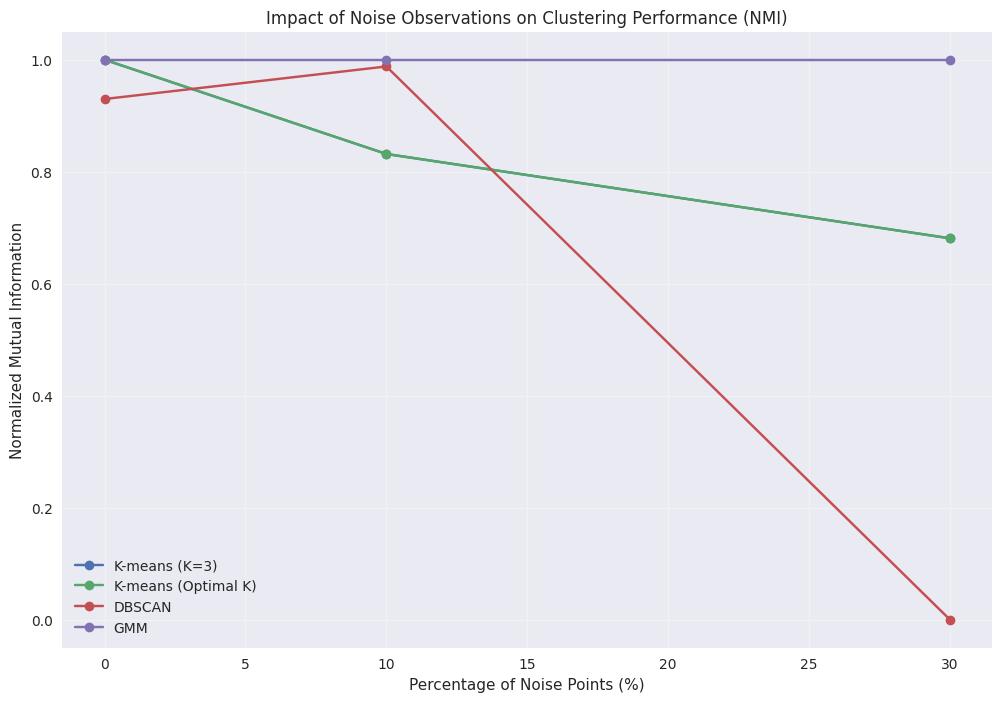

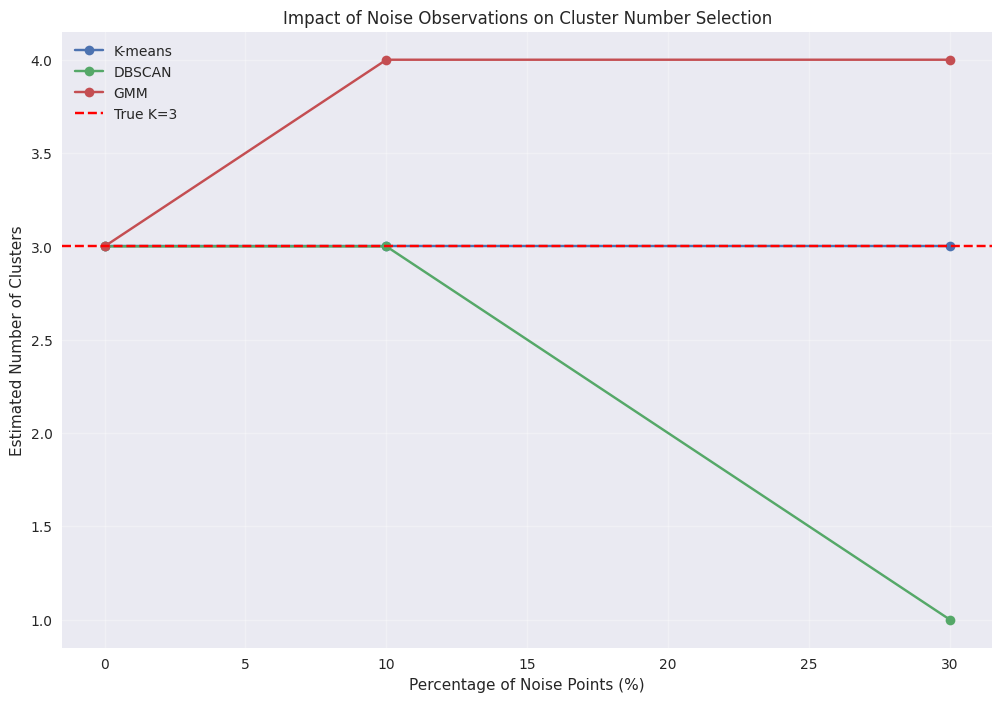

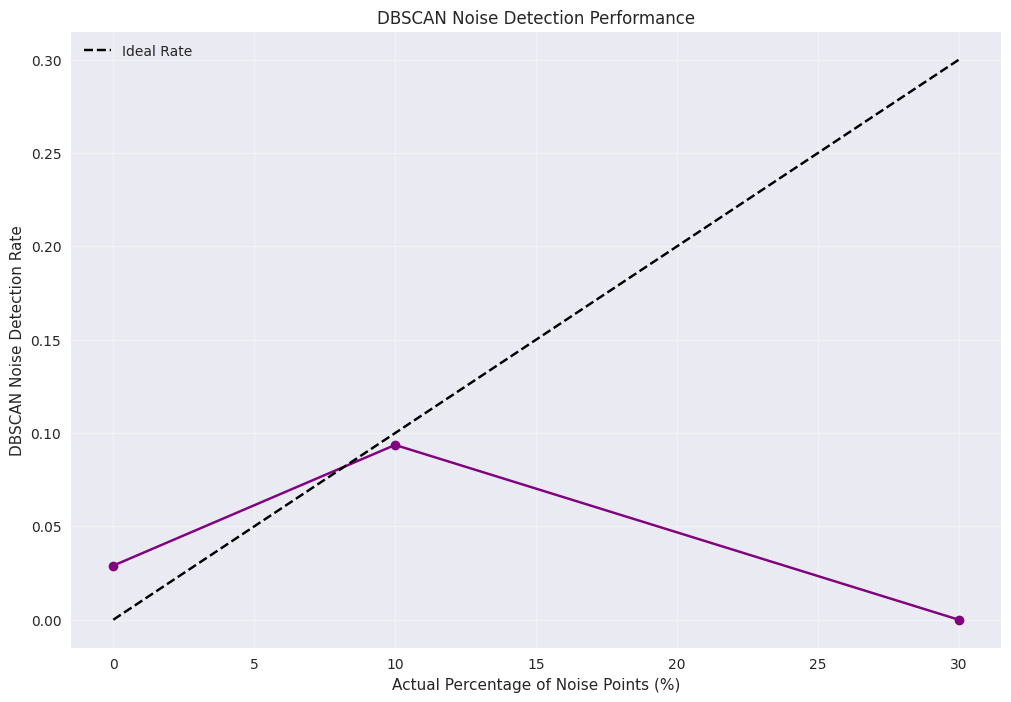


Experiments complete.

Summary:

Part A: Impact of Irrelevant Features
----------------------------------------

ARI values as noise features increase:
K-means: ['1.000', '1.000', '1.000']
DBSCAN: ['0.956', '0.001', '0.000']
GMM: ['1.000', '0.000', '1.000']

Part B: Impact of Noise Observations
----------------------------------------

Noise detection rates:
With 10% noise points, DBSCAN identifies 9.36% as noise (Ideal: 9.09%)
With 30% noise points, DBSCAN identifies 0.00% as noise (Ideal: 23.08%)

Impact on Cluster Number Selection
----------------------------------------
Part A: As noise features increase:
K-means: ['3.0', '3.0', '3.0']
DBSCAN: ['3.0', '1.0', '0.0']
GMM: ['3.0', '1.0', '3.0']

Part B: As noise percentage increases:
K-means: ['3.0', '3.0', '3.0']
DBSCAN: ['3.0', '3.0', '1.0']
GMM: ['3.0', '4.0', '4.0']


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import pdist
from kneed import KneeLocator
from tqdm import tqdm
import umap
import warnings
warnings.filterwarnings('ignore')

# Set default plot settings for Jupyter notebook
# %matplotlib inline
plt.style.use('seaborn-v0_8')


def generate_base_data(n_samples=1000, n_features=10, n_clusters=3, random_state=42):
    """Generate base dataset with well-defined clusters"""
    X, y = make_blobs(n_samples=n_samples, 
                      n_features=n_features, 
                      centers=n_clusters,
                      cluster_std=1.0,
                      random_state=random_state)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y


def add_noise_features(X, n_noise_features, random_state=42):
    """Add irrelevant noise features to the dataset"""
    np.random.seed(random_state)
    n_samples = X.shape[0]
    
    # Generate noise features from normal distribution
    noise_features = np.random.normal(0, 1, size=(n_samples, n_noise_features))
    
    # Standardize noise features
    noise_features = StandardScaler().fit_transform(noise_features)
    
    # Combine original features with noise features
    X_with_noise = np.hstack((X, noise_features))
    
    return X_with_noise


def add_noise_observations(X, y, noise_percentage, random_state=42):
    """Add observations that don't belong to any cluster"""
    np.random.seed(random_state)
    n_samples, n_features = X.shape
    n_noise = int(n_samples * (noise_percentage / 100))
    
    # Use mean ± 3*std for bounds
    feature_means = np.mean(X, axis=0)
    feature_stds = np.std(X, axis=0)
    min_vals = feature_means - 3 * feature_stds
    max_vals = feature_means + 3 * feature_stds
    
    # Generate random noise points
    noise_points = np.array([np.random.uniform(min_vals[j], max_vals[j], n_noise) 
                             for j in range(n_features)]).T
    
    # Add noise points to dataset
    X_with_noise_obs = np.vstack((X, noise_points))
    y_with_noise_obs = np.append(y, [-1] * n_noise)  # Mark noise as -1
    
    return X_with_noise_obs, y_with_noise_obs


def estimate_optimal_eps(X, k=5):
    """Estimate optimal epsilon for DBSCAN using k-distance plot"""
    # Compute k-nearest neighbor distances
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    
    # Sort distances
    distances = np.sort(distances[:, k-1])
    
    # Find the knee point
    try:
        knee_locator = KneeLocator(
            range(len(distances)), 
            distances, 
            curve='convex', 
            direction='increasing'
        )
        knee = knee_locator.knee
        if knee is not None:
            eps = distances[knee]
        else:
            # If knee is not found, use heuristic
            eps = np.percentile(distances, 90)
    except:
        # Fallback if KneeLocator fails
        eps = np.percentile(distances, 90)
    
    return eps


def select_optimal_k(X, max_k=10):
    """Select optimal K for K-means using Elbow method"""
    inertias = []
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Find the elbow point
    try:
        knee_locator = KneeLocator(
            range(1, len(inertias)+1), 
            inertias, 
            curve='convex', 
            direction='decreasing'
        )
        optimal_k = knee_locator.elbow
        if optimal_k is None:
            optimal_k = 3  # Default to 3 if no clear elbow
    except:
        # Fallback if KneeLocator fails
        optimal_k = 3
    
    return optimal_k


def select_optimal_components_bic(X, max_components=10):
    """Select optimal number of components for GMM using BIC"""
    bic_values = []
    for n in range(1, max_components+1):
        # Allow variability in GMM
        gmm = GaussianMixture(n_components=n, n_init=5)
        gmm.fit(X)
        bic_values.append(gmm.bic(X))
    
    # Find the minimum BIC
    optimal_n = np.argmin(bic_values) + 1
    
    return optimal_n


def evaluate_clustering(X, true_labels, noise_percentage=0, n_noise_features=0):
    """Evaluate different clustering methods"""
    results = {}
    
    # K-means with true K=3
    kmeans_true_k = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_pred = kmeans_true_k.fit_predict(X)
    results['kmeans_true_k'] = {
        'ari': adjusted_rand_score(true_labels, kmeans_pred),
        'nmi': normalized_mutual_info_score(true_labels, kmeans_pred)
    }
    
    # K-means with optimal K
    optimal_k = select_optimal_k(X)
    kmeans_opt_k = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_opt_pred = kmeans_opt_k.fit_predict(X)
    results['kmeans_optimal_k'] = {
        'ari': adjusted_rand_score(true_labels, kmeans_opt_pred),
        'nmi': normalized_mutual_info_score(true_labels, kmeans_opt_pred),
        'estimated_k': optimal_k
    }
    
    # DBSCAN
    eps = estimate_optimal_eps(X)
    # Better min_samples tuning based on dimensionality
    min_samples = max(5, 2 * X.shape[1])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_pred = dbscan.fit_predict(X)
    
    # Calculate DBSCAN metrics
    # Handle the case where all points might be labeled as noise (-1)
    if set(dbscan_pred) == {-1}:
        results['dbscan'] = {
            'ari': 0,
            'nmi': 0,
            'estimated_k': 0,
            'noise_detection_rate': np.sum(dbscan_pred == -1) / len(dbscan_pred)
        }
    else:
        # Calculate number of clusters (excluding noise points)
        dbscan_k = len(set(dbscan_pred[dbscan_pred != -1]))
        results['dbscan'] = {
            'ari': adjusted_rand_score(true_labels, dbscan_pred),
            'nmi': normalized_mutual_info_score(true_labels, dbscan_pred),
            'estimated_k': dbscan_k,
            'noise_detection_rate': np.sum(dbscan_pred == -1) / len(dbscan_pred)
        }
    
    # GMM
    optimal_components = select_optimal_components_bic(X)
    # Allow variability in GMM
    gmm = GaussianMixture(n_components=optimal_components, n_init=5)
    gmm_pred = gmm.fit_predict(X)
    results['gmm'] = {
        'ari': adjusted_rand_score(true_labels, gmm_pred),
        'nmi': normalized_mutual_info_score(true_labels, gmm_pred),
        'estimated_k': optimal_components
    }
    
    # Add noise information to results
    results['metadata'] = {
        'noise_percentage': noise_percentage,
        'n_noise_features': n_noise_features
    }
    
    return results


def visualize_clusters(X, labels, title, method_name, noise_info=""):
    """Visualize clusters using PCA or UMAP"""
    # Use PCA for datasets with fewer than 50 features, otherwise UMAP (faster than t-SNE)
    if X.shape[1] < 50:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        vis_method = "PCA"
    else:
        # Using UMAP with optimized parameters for speed
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
        X_2d = reducer.fit_transform(X)
        vis_method = "UMAP"
    
    # Create plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    
    # Add legend
    unique_labels = np.unique(labels)
    if -1 in unique_labels:  # If there are noise points
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             label=f'Cluster {i}' if i != -1 else 'Noise',
                             markerfacecolor=scatter.cmap(scatter.norm(i)), 
                             markersize=10) 
                   for i in unique_labels]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             label=f'Cluster {i}',
                             markerfacecolor=scatter.cmap(scatter.norm(i)), 
                             markersize=10) 
                   for i in unique_labels]
        
    plt.legend(handles=handles)
    
    # Add detailed title with noise info
    full_title = f'{title} - {method_name} ({vis_method} Projection)'
    if noise_info:
        full_title += f'\n{noise_info}'
    plt.title(full_title)
    
    plt.xlabel(f'{vis_method} Component 1')
    plt.ylabel(f'{vis_method} Component 2')
    plt.tight_layout()
    
    # Display plot inline in notebook (don't save to file)
    plt.show()


def run_experiment_part_a(n_repetitions=1):
    """Run experiment for Part A: Impact of additional irrelevant features"""
    # Reduce feature levels to speed up execution
    noise_feature_levels = [0, 50, 500]
    
    # Initialize results storage
    all_results = {level: [] for level in noise_feature_levels}
    
    # Use tqdm for progress tracking
    for rep in tqdm(range(n_repetitions), desc="Part A Repetitions"):
        # Generate base dataset with different random seed per repetition
        X_base, y_base = generate_base_data(random_state=42+rep)
        
        for noise_level in tqdm(noise_feature_levels, desc="Noise Features", leave=False):
            # Add noise features
            if noise_level > 0:
                X_noisy = add_noise_features(X_base, noise_level, random_state=42+rep)
            else:
                X_noisy = X_base.copy()
            
            # Evaluate clustering
            results = evaluate_clustering(X_noisy, y_base, n_noise_features=noise_level)
            all_results[noise_level].append(results)
            
            # Visualize clusters (show in notebook)
            noise_info = f"{noise_level} Noise Features"
            
            # Visualize the true clusters
            visualize_clusters(X_noisy, y_base, "True Clusters", "Ground Truth", noise_info=noise_info)
            
            # Visualize K-means clustering
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            kmeans_labels = kmeans.fit_predict(X_noisy)
            visualize_clusters(X_noisy, kmeans_labels, "K-means Clustering", "K=3", noise_info=noise_info)
            
            # Visualize DBSCAN clustering
            eps = estimate_optimal_eps(X_noisy)
            min_samples = max(5, 2 * X_noisy.shape[1])
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X_noisy)
            visualize_clusters(X_noisy, dbscan_labels, "DBSCAN Clustering", 
                               f"eps={eps:.2f}, min_samples={min_samples}", noise_info=noise_info)
            
            # Visualize GMM clustering
            optimal_components = select_optimal_components_bic(X_noisy)
            gmm = GaussianMixture(n_components=optimal_components, n_init=5)
            gmm_labels = gmm.fit_predict(X_noisy)
            visualize_clusters(X_noisy, gmm_labels, "GMM Clustering", 
                               f"Components={optimal_components}", noise_info=noise_info)
    
    # Aggregate results
    aggregated_results = {}
    for noise_level in noise_feature_levels:
        level_results = all_results[noise_level]
        
        # Initialize aggregation
        agg = {'kmeans_true_k': {'ari': [], 'nmi': []},
               'kmeans_optimal_k': {'ari': [], 'nmi': [], 'estimated_k': []},
               'dbscan': {'ari': [], 'nmi': [], 'estimated_k': [], 'noise_detection_rate': []},
               'gmm': {'ari': [], 'nmi': [], 'estimated_k': []}}
        
        # Collect metrics across repetitions
        for rep_result in level_results:
            for method in ['kmeans_true_k', 'kmeans_optimal_k', 'dbscan', 'gmm']:
                for metric in rep_result[method]:
                    agg[method][metric].append(rep_result[method][metric])
        
        # FIX: Use list of keys to avoid dictionary modification during iteration
        for method in agg:
            metrics = list(agg[method].keys())  # Create a list of keys
            for metric in metrics:
                values = agg[method][metric]
                agg[method][f'{metric}_mean'] = np.mean(values)
                agg[method][f'{metric}_std'] = np.std(values)
        
        aggregated_results[noise_level] = agg
    
    # Plot results
    plot_part_a_results(aggregated_results, noise_feature_levels)
    
    return aggregated_results


def run_experiment_part_b(n_repetitions=1):
    """Run experiment for Part B: Impact of noise observations"""
    # Reduce noise percentages to speed up execution
    noise_percentages = [0, 10, 30]
    
    # Initialize results storage
    all_results = {pct: [] for pct in noise_percentages}
    
    # Use tqdm for progress tracking
    for rep in tqdm(range(n_repetitions), desc="Part B Repetitions"):
        # Generate base dataset with different random seed per repetition
        X_base, y_base = generate_base_data(random_state=42+rep)
        
        for noise_pct in tqdm(noise_percentages, desc="Noise Percentages", leave=False):
            # Add noise observations
            if noise_pct > 0:
                X_noisy, y_noisy = add_noise_observations(X_base, y_base, noise_pct, random_state=42+rep)
            else:
                X_noisy, y_noisy = X_base.copy(), y_base.copy()
            
            # Evaluate clustering
            results = evaluate_clustering(X_noisy, y_noisy, noise_percentage=noise_pct)
            all_results[noise_pct].append(results)
            
            # Visualize clusters (show in notebook)
            noise_info = f"{noise_pct}% Noise Points"
            
            # Visualize the true clusters
            visualize_clusters(X_noisy, y_noisy, "True Clusters", "Ground Truth", noise_info=noise_info)
            
            # Visualize K-means clustering
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            kmeans_labels = kmeans.fit_predict(X_noisy)
            visualize_clusters(X_noisy, kmeans_labels, "K-means Clustering", "K=3", noise_info=noise_info)
            
            # Visualize DBSCAN clustering
            eps = estimate_optimal_eps(X_noisy)
            min_samples = max(5, 2 * X_noisy.shape[1])
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(X_noisy)
            visualize_clusters(X_noisy, dbscan_labels, "DBSCAN Clustering", 
                               f"eps={eps:.2f}, min_samples={min_samples}", noise_info=noise_info)
            
            # Visualize GMM clustering
            optimal_components = select_optimal_components_bic(X_noisy)
            gmm = GaussianMixture(n_components=optimal_components, n_init=5)
            gmm_labels = gmm.fit_predict(X_noisy)
            visualize_clusters(X_noisy, gmm_labels, "GMM Clustering", 
                               f"Components={optimal_components}", noise_info=noise_info)
    
    # Aggregate results
    aggregated_results = {}
    for noise_pct in noise_percentages:
        level_results = all_results[noise_pct]
        
        # Initialize aggregation
        agg = {'kmeans_true_k': {'ari': [], 'nmi': []},
               'kmeans_optimal_k': {'ari': [], 'nmi': [], 'estimated_k': []},
               'dbscan': {'ari': [], 'nmi': [], 'estimated_k': [], 'noise_detection_rate': []},
               'gmm': {'ari': [], 'nmi': [], 'estimated_k': []}}
        
        # Collect metrics across repetitions
        for rep_result in level_results:
            for method in ['kmeans_true_k', 'kmeans_optimal_k', 'dbscan', 'gmm']:
                for metric in rep_result[method]:
                    agg[method][metric].append(rep_result[method][metric])
        
        # FIX: Use list of keys to avoid dictionary modification during iteration
        for method in agg:
            metrics = list(agg[method].keys())  # Create a list of keys
            for metric in metrics:
                values = agg[method][metric]
                agg[method][f'{metric}_mean'] = np.mean(values)
                agg[method][f'{metric}_std'] = np.std(values)
        
        aggregated_results[noise_pct] = agg
    
    # Plot results
    plot_part_b_results(aggregated_results, noise_percentages)
    
    return aggregated_results


def plot_part_a_results(results, noise_levels):
    """Plot results for Part A: Impact of irrelevant features"""
    # Convert to dataframes for easier plotting
    df_ari = pd.DataFrame({
        'Noise Features': noise_levels,
        'K-means (K=3)': [results[level]['kmeans_true_k']['ari_mean'] for level in noise_levels],
        'K-means (Optimal K)': [results[level]['kmeans_optimal_k']['ari_mean'] for level in noise_levels],
        'DBSCAN': [results[level]['dbscan']['ari_mean'] for level in noise_levels],
        'GMM': [results[level]['gmm']['ari_mean'] for level in noise_levels]
    })
    
    df_nmi = pd.DataFrame({
        'Noise Features': noise_levels,
        'K-means (K=3)': [results[level]['kmeans_true_k']['nmi_mean'] for level in noise_levels],
        'K-means (Optimal K)': [results[level]['kmeans_optimal_k']['nmi_mean'] for level in noise_levels],
        'DBSCAN': [results[level]['dbscan']['nmi_mean'] for level in noise_levels],
        'GMM': [results[level]['gmm']['nmi_mean'] for level in noise_levels]
    })
    
    df_k = pd.DataFrame({
        'Noise Features': noise_levels,
        'K-means': [results[level]['kmeans_optimal_k']['estimated_k_mean'] for level in noise_levels],
        'DBSCAN': [results[level]['dbscan']['estimated_k_mean'] for level in noise_levels],
        'GMM': [results[level]['gmm']['estimated_k_mean'] for level in noise_levels]
    })
    
    # Plot ARI with both fixed and optimal K-means
    plt.figure(figsize=(12, 8))
    for method in ['K-means (K=3)', 'K-means (Optimal K)', 'DBSCAN', 'GMM']:
        plt.plot(df_ari['Noise Features'], df_ari[method], marker='o', label=method)
    plt.xscale('symlog')
    plt.xlabel('Number of Noise Features (log scale)')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Impact of Irrelevant Features on Clustering Performance (ARI)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot NMI
    plt.figure(figsize=(12, 8))
    for method in ['K-means (K=3)', 'K-means (Optimal K)', 'DBSCAN', 'GMM']:
        plt.plot(df_nmi['Noise Features'], df_nmi[method], marker='o', label=method)
    plt.xscale('symlog')
    plt.xlabel('Number of Noise Features (log scale)')
    plt.ylabel('Normalized Mutual Information')
    plt.title('Impact of Irrelevant Features on Clustering Performance (NMI)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Estimated K
    plt.figure(figsize=(12, 8))
    for method in ['K-means', 'DBSCAN', 'GMM']:
        plt.plot(df_k['Noise Features'], df_k[method], marker='o', label=method)
    plt.xscale('symlog')
    plt.xlabel('Number of Noise Features (log scale)')
    plt.ylabel('Estimated Number of Clusters')
    plt.title('Impact of Irrelevant Features on Cluster Number Selection')
    plt.axhline(y=3, color='r', linestyle='--', label='True K=3')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_part_b_results(results, noise_percentages):
    """Plot results for Part B: Impact of noise observations"""
    # Convert to dataframes for easier plotting
    df_ari = pd.DataFrame({
        'Noise Percentage': noise_percentages,
        'K-means (K=3)': [results[pct]['kmeans_true_k']['ari_mean'] for pct in noise_percentages],
        'K-means (Optimal K)': [results[pct]['kmeans_optimal_k']['ari_mean'] for pct in noise_percentages],
        'DBSCAN': [results[pct]['dbscan']['ari_mean'] for pct in noise_percentages],
        'GMM': [results[pct]['gmm']['ari_mean'] for pct in noise_percentages]
    })
    
    df_nmi = pd.DataFrame({
        'Noise Percentage': noise_percentages,
        'K-means (K=3)': [results[pct]['kmeans_true_k']['nmi_mean'] for pct in noise_percentages],
        'K-means (Optimal K)': [results[pct]['kmeans_optimal_k']['nmi_mean'] for pct in noise_percentages],
        'DBSCAN': [results[pct]['dbscan']['nmi_mean'] for pct in noise_percentages],
        'GMM': [results[pct]['gmm']['nmi_mean'] for pct in noise_percentages]
    })
    
    df_k = pd.DataFrame({
        'Noise Percentage': noise_percentages,
        'K-means': [results[pct]['kmeans_optimal_k']['estimated_k_mean'] for pct in noise_percentages],
        'DBSCAN': [results[pct]['dbscan']['estimated_k_mean'] for pct in noise_percentages],
        'GMM': [results[pct]['gmm']['estimated_k_mean'] for pct in noise_percentages]
    })
    
    # For DBSCAN only - noise detection rate
    df_noise_detection = pd.DataFrame({
        'Noise Percentage': noise_percentages,
        'DBSCAN Noise Detection Rate': [results[pct]['dbscan']['noise_detection_rate_mean'] for pct in noise_percentages]
    })
    
    # Plot ARI
    plt.figure(figsize=(12, 8))
    for method in ['K-means (K=3)', 'K-means (Optimal K)', 'DBSCAN', 'GMM']:
        plt.plot(df_ari['Noise Percentage'], df_ari[method], marker='o', label=method)
    plt.xlabel('Percentage of Noise Points (%)')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Impact of Noise Observations on Clustering Performance (ARI)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot NMI
    plt.figure(figsize=(12, 8))
    for method in ['K-means (K=3)', 'K-means (Optimal K)', 'DBSCAN', 'GMM']:
        plt.plot(df_nmi['Noise Percentage'], df_nmi[method], marker='o', label=method)
    plt.xlabel('Percentage of Noise Points (%)')
    plt.ylabel('Normalized Mutual Information')
    plt.title('Impact of Noise Observations on Clustering Performance (NMI)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot Estimated K
    plt.figure(figsize=(12, 8))
    for method in ['K-means', 'DBSCAN', 'GMM']:
        plt.plot(df_k['Noise Percentage'], df_k[method], marker='o', label=method)
    plt.xlabel('Percentage of Noise Points (%)')
    plt.ylabel('Estimated Number of Clusters')
    plt.title('Impact of Noise Observations on Cluster Number Selection')
    plt.axhline(y=3, color='r', linestyle='--', label='True K=3')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot DBSCAN Noise Detection Rate
    plt.figure(figsize=(12, 8))
    plt.plot(df_noise_detection['Noise Percentage'], 
             df_noise_detection['DBSCAN Noise Detection Rate'], 
             marker='o', color='purple')
    
    # Add line showing ideal noise detection rate
    plt.plot(df_noise_detection['Noise Percentage'],
             df_noise_detection['Noise Percentage'] / 100,
             'k--', label='Ideal Rate')
    
    plt.xlabel('Actual Percentage of Noise Points (%)')
    plt.ylabel('DBSCAN Noise Detection Rate')
    plt.title('DBSCAN Noise Detection Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def print_summary(part_a_results, part_b_results):
    """Print summary of results"""
    print("\nSummary:")
    print("=" * 50)
    
    print("\nPart A: Impact of Irrelevant Features")
    print("-" * 40)
    
    # Report on ARI performance drops
    noise_levels = sorted(part_a_results.keys())
    
    print("\nARI values as noise features increase:")
    for method in ['K-means', 'DBSCAN', 'GMM']:
        key = 'kmeans_optimal_k' if method == 'K-means' else method.lower()
        ari_values = [f"{part_a_results[level][key]['ari_mean']:.3f}" for level in noise_levels]
        print(f"{method}: {ari_values}")
    
    print("\nPart B: Impact of Noise Observations")
    print("-" * 40)
    
    # Calculate DBSCAN's accuracy in identifying noise points
    noise_percentages = sorted(part_b_results.keys())
    
    print("\nNoise detection rates:")
    for noise_pct in [pct for pct in noise_percentages if pct > 0]:
        noise_detection = part_b_results[noise_pct]['dbscan']['noise_detection_rate_mean']
        actual_noise_ratio = noise_pct / (100 + noise_pct)  # Adjusted for total observations
        print(f"With {noise_pct}% noise points, DBSCAN identifies {noise_detection:.2%} as noise (Ideal: {actual_noise_ratio:.2%})")
    
    print("\nImpact on Cluster Number Selection")
    print("-" * 40)
    
    # Compare estimated K vs true K=3
    print("Part A: As noise features increase:")
    for method in ['K-means', 'DBSCAN', 'GMM']:
        key = 'kmeans_optimal_k' if method == 'K-means' else method.lower()
        k_estimates = [f"{part_a_results[level][key]['estimated_k_mean']:.1f}" for level in noise_levels]
        print(f"{method}: {k_estimates}")
    
    print("\nPart B: As noise percentage increases:")
    for method in ['K-means', 'DBSCAN', 'GMM']:
        key = 'kmeans_optimal_k' if method == 'K-means' else method.lower()
        k_estimates = [f"{part_b_results[pct][key]['estimated_k_mean']:.1f}" for pct in noise_percentages]
        print(f"{method}: {k_estimates}")


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    print("Starting experiment Part A: Impact of irrelevant features")
    part_a_results = run_experiment_part_a(n_repetitions=1)
    
    print("\nStarting experiment Part B: Impact of noise observations")
    part_b_results = run_experiment_part_b(n_repetitions=1)
    
    print("\nExperiments complete.")
    
    # Print summary of results
    print_summary(part_a_results, part_b_results)